In [20]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
#for ntebook Jupyter
%matplotlib inline 
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport #need to add for compatability

#print("python:", sys.executable)
#print("pandas:", pd.__version__)


In [5]:
#my directory of the data- change to your directory of ddata
DATA_DIR = Path(r"C:\Users\Owner\Documents\datsci\rents")#change to where the csv files are, this is where we will read the data

#where the outputs are  gonna be
OUT_DIR  = Path(r"C:\Users\Owner\Documents\GitHub\DAT490\data") #change to where you want the data to go
OUT_DIR.mkdir(parents=True, exist_ok=True)
METRO_FILES = {
    "phoenix":     DATA_DIR / "final_zcta_dataset_phoenix.csv",
    "memphis":     DATA_DIR / "final_zcta_dataset_memphis.csv",
    "los_angeles": DATA_DIR / "final_zcta_dataset_los_angeles.csv",
    "dallas":      DATA_DIR / "final_zcta_dataset_dallas.csv",
}
#new directory for names
METRO_NAMES = {
    "phoenix": "Phoenix-Mesa-Chandler, AZ",
    "memphis": "Memphis, TN-MS-AR",
    "los_angeles": "Los Angeles-Long Beach-Anaheim, CA",
    "dallas": "Dallas-Fort Worth-Arlington, TX"
}


#keep this for spatial analysis
METRO_CONFIGS = {
    "phoenix": {
        "name": "Phoenix-Mesa-Chandler, AZ",
        "cbsa_code": "38060",
        "state_fips": "04",
        "county_fips_list": ["013", "021"],
        "zip_prefixes": ["85"],
        "utm_zone": 32612
    },
    "memphis": {
        "name": "Memphis, TN-MS-AR",
        "cbsa_code": "32820",
        "state_fips": "47",
        "county_fips_list": ["157", "047", "033"],
        "zip_prefixes": ["38", "72"],
        "utm_zone": 32616
    },
    "los_angeles": {
        "name": "Los Angeles-Long Beach-Anaheim, CA",
        "cbsa_code": "31080",
        "state_fips": "06",
        "county_fips_list": ["037"],
        "zip_prefixes": ["90", "91"],
        "utm_zone": 32611
    },
    "dallas": { #keeping dfw as it is to simplify things, just added collin fipscode
        #ping me for more cbsa codes if desired.. i was able to find them
        "name": "Dallas-Fort Worth-Arlington, TX",
        "cbsa_code": "19100",
        "state_fips": "48",
        "county_fips_list": ["113", "085", "121", "257", "439"],
        "zip_prefixes": ["75", "76"],
        "utm_zone": 32614
    }
}


In [7]:
#put in date time format and make sure we are in numeric
def light_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    #date time formatting
    if "period" in df.columns:
        df["period"] = pd.to_datetime(df["period"], errors="coerce")
    #enforce numeric type where it needs to be just in case
    for col in ["rent_to_income", "long45_share", "long60_share", 
                "commute_min_proxy", "ttw_total", "zori", "stops_per_km2"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

In [8]:
#this is our join. We will be keeping the above directory untouched for now
frames = []

for key, path in METRO_FILES.items():
    print(f"Loading {METRO_NAMES[key]} from {path}...")
    
    temp = pd.read_csv(path, low_memory=False)
    temp = light_clean(temp)
    
    # Tag the metro identity
    temp["metro_key"]  = key
    temp["metro_name"] = METRO_NAMES[key]
    
    frames.append(temp)

df = pd.concat(frames, ignore_index=True)

df.shape, df.head()

Loading Phoenix-Mesa-Chandler, AZ from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_phoenix.csv...
Loading Memphis, TN-MS-AR from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_memphis.csv...
Loading Los Angeles-Long Beach-Anaheim, CA from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_los_angeles.csv...
Loading Dallas-Fort Worth-Arlington, TX from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_dallas.csv...


((649, 11),
    ZCTA5CE  rent_to_income  long45_share  long60_share  commute_min_proxy  \
 0    85003        0.291375      0.068853      0.059311           5.513359   
 1    85004        0.382202      0.096454      0.065302           6.517524   
 2    85006        0.243999      0.050274      0.033701           3.614925   
 3    85007        0.255801      0.106325      0.078456           7.746845   
 4    85008        0.264548      0.076328      0.052986           5.717924   
 
    ttw_total     period         zori  stops_per_km2 metro_key  \
 0     2788.0 2025-09-30  1781.142157      17.295065   phoenix   
 1     5738.0 2025-09-30  1824.106878      18.415723   phoenix   
 2     9884.0 2025-09-30  1438.695628      12.964971   phoenix   
 3     5308.0 2025-09-30  1450.002646      11.023520   phoenix   
 4    29411.0 2025-09-30  1457.858483       6.127955   phoenix   
 
                   metro_name  
 0  Phoenix-Mesa-Chandler, AZ  
 1  Phoenix-Mesa-Chandler, AZ  
 2  Phoenix-Mesa-Chandle

In [9]:
#ok so we can start a basic EDA
#shape(649,11)
df.describe(include='all')


,ZCTA5CE,rent_to_income,long45_share,long60_share,commute_min_proxy,ttw_total,period,zori,stops_per_km2,metro_key,metro_name
count,649.000000,637.000000,645.000000,645.000000,645.000000,649.000000,573,573.000000,649.000000,649,649
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,los_angeles,"Los Angeles-Long Beach-Anaheim, CA"
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270,270
mean,81865.329738,0.259754,0.166620,0.119197,11.998339,13333.212635,2025-09-30 00:00:00,2335.388719,3.519767,NaN,NaN
min,38002.000000,0.085953,0.022608,0.012439,1.538381,0.000000,2025-09-30 00:00:00,917.729377,0.000000,NaN,NaN
25%,76018.000000,0.225513,0.122644,0.081910,8.731680,7229.000000,2025-09-30 00:00:00,1671.714902,0.020870,NaN,NaN
50%,85268.000000,0.255801,0.166713,0.117527,12.024840,12618.000000,2025-09-30 00:00:00,2137.083333,1.167294,NaN,NaN
75%,90403.000000,0.289921,0.203986,0.149506,14.922152,17946.000000,2025-09-30 00:00:00,2755.455863,4.907871,NaN,NaN
max,91803.000000,0.580212,0.394507,0.305380,28.313399,44521.000000,2025-09-30 00:00:00,12446.388889,53.879431,NaN,NaN


In [10]:
#missing data. lets deal with this later :)
df.isna().mean().sort_values(ascending=False)



period               0.117103
zori                 0.117103
rent_to_income       0.018490
commute_min_proxy    0.006163
long45_share         0.006163
long60_share         0.006163
ZCTA5CE              0.000000
ttw_total            0.000000
stops_per_km2        0.000000
metro_key            0.000000
metro_name           0.000000
dtype: float64

In [11]:
from ydata_profiling import ProfileReport
Profile = ProfileReport(df, title="Affordability + Commute Profile")
Profile.to_file("Affordability_EDA_Report.html")


Export report to file: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.04it/s]


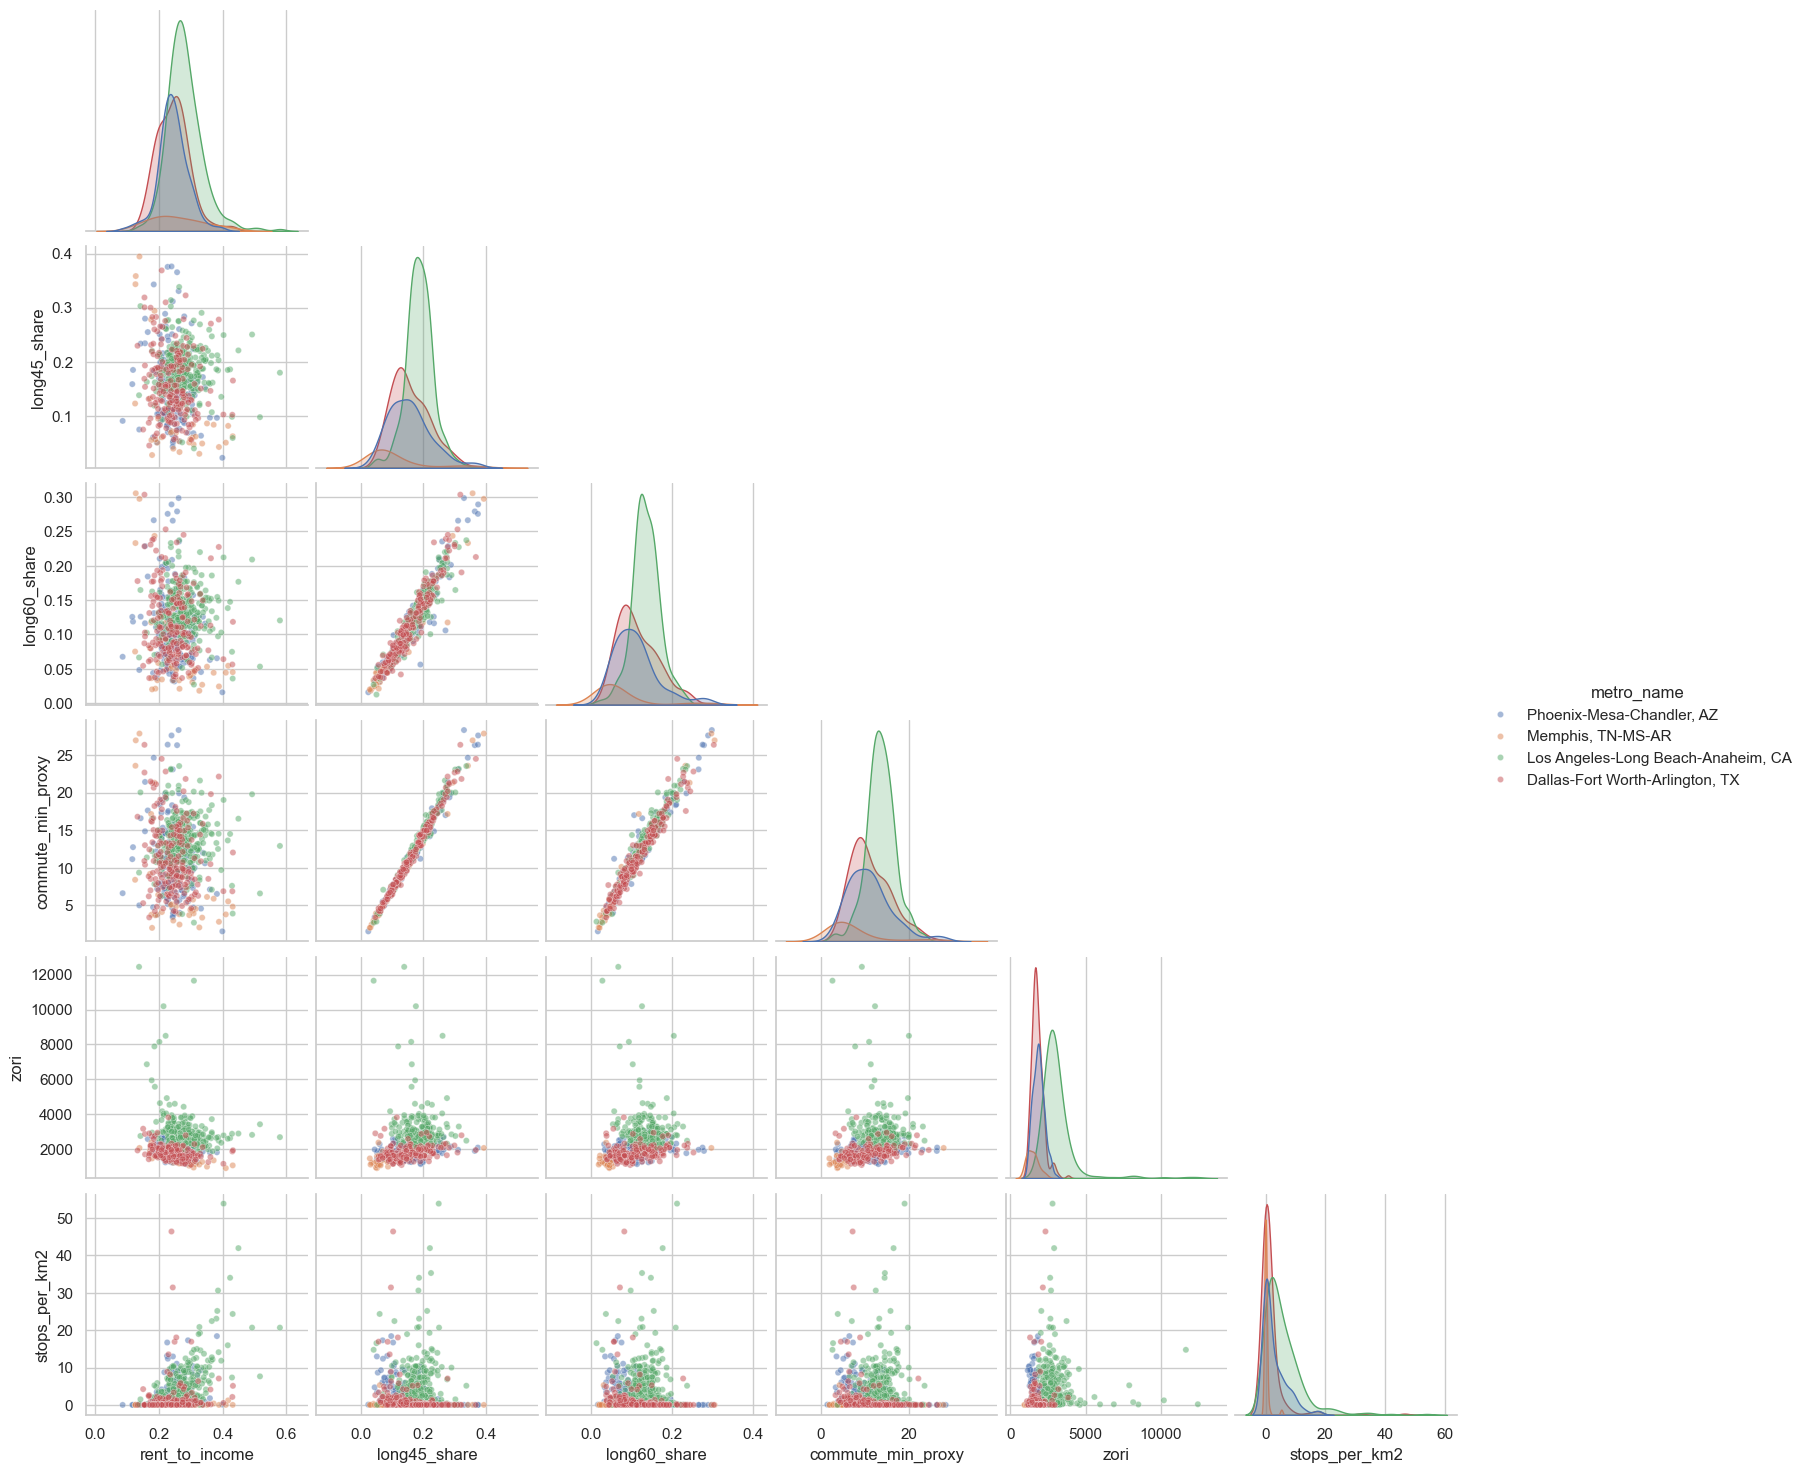

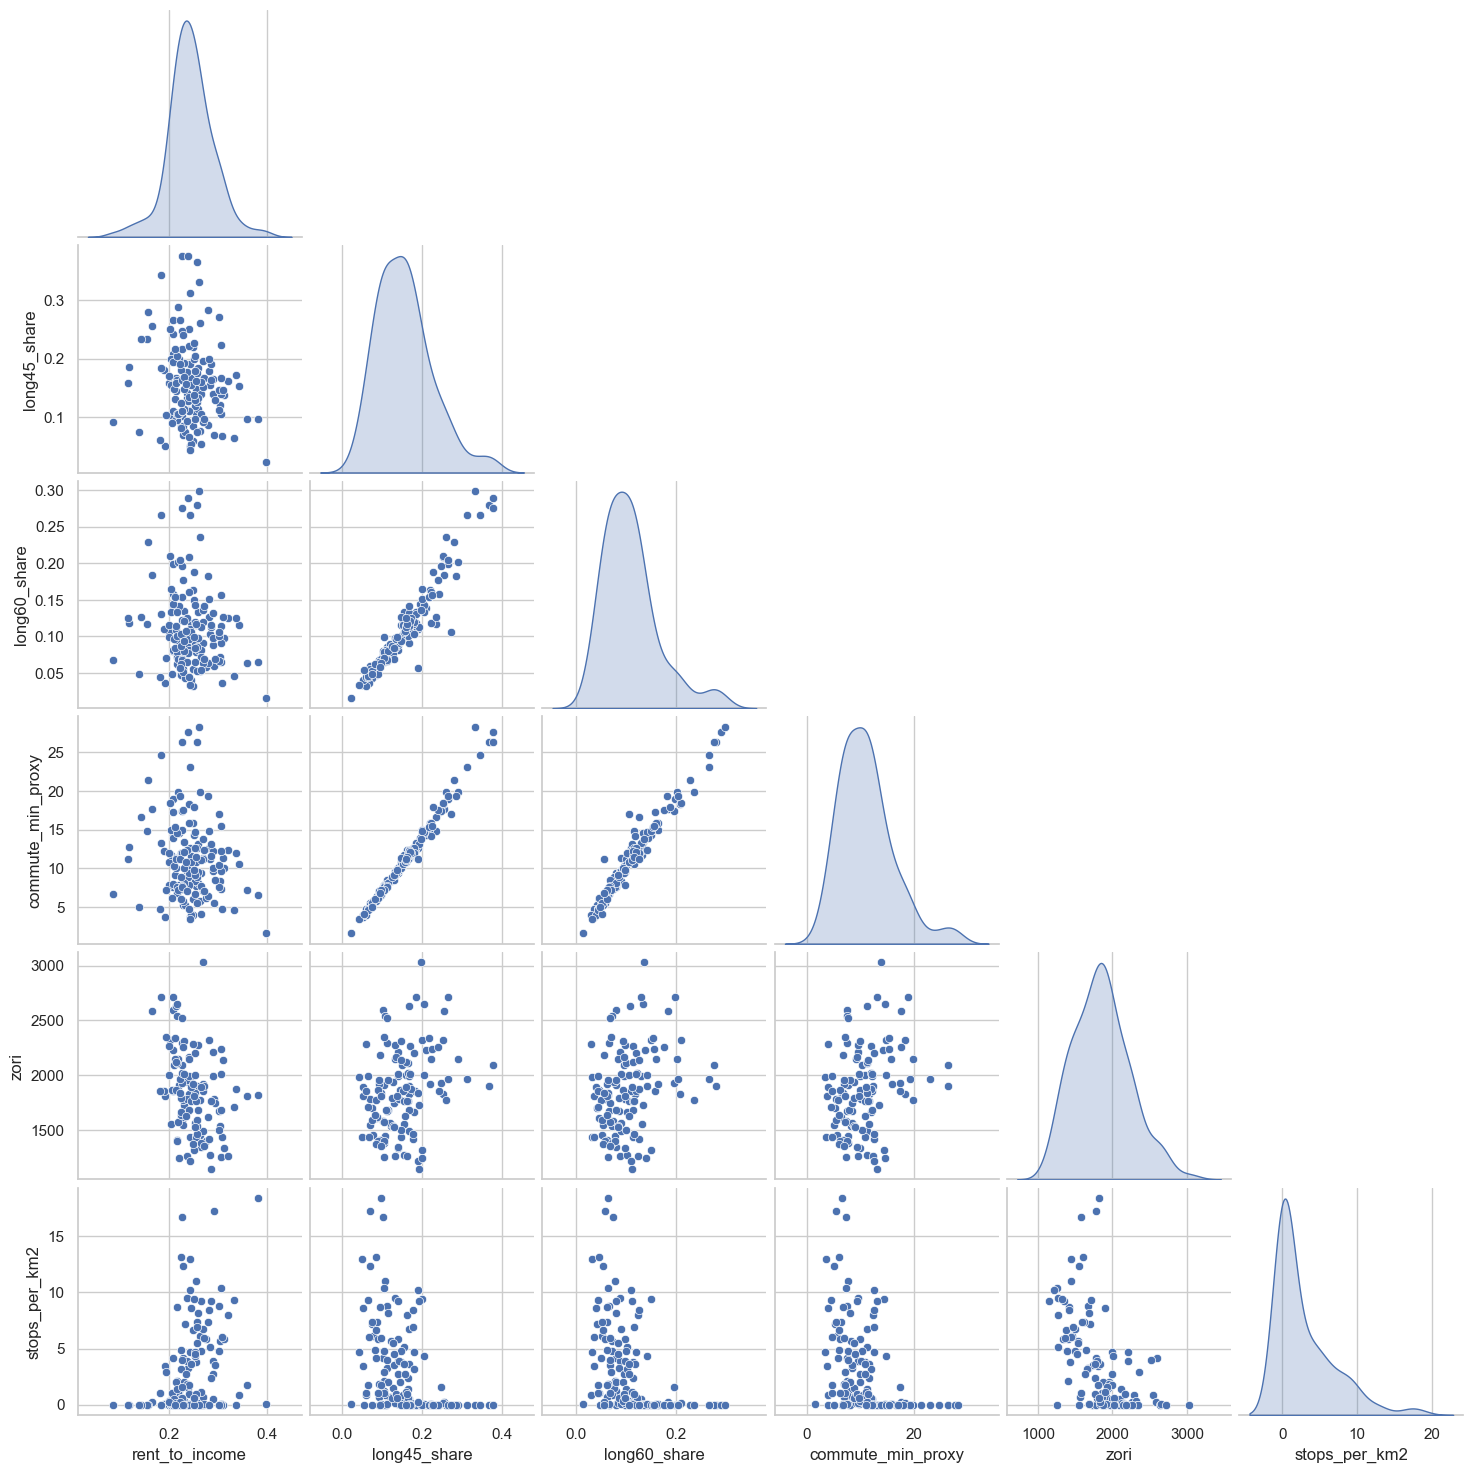

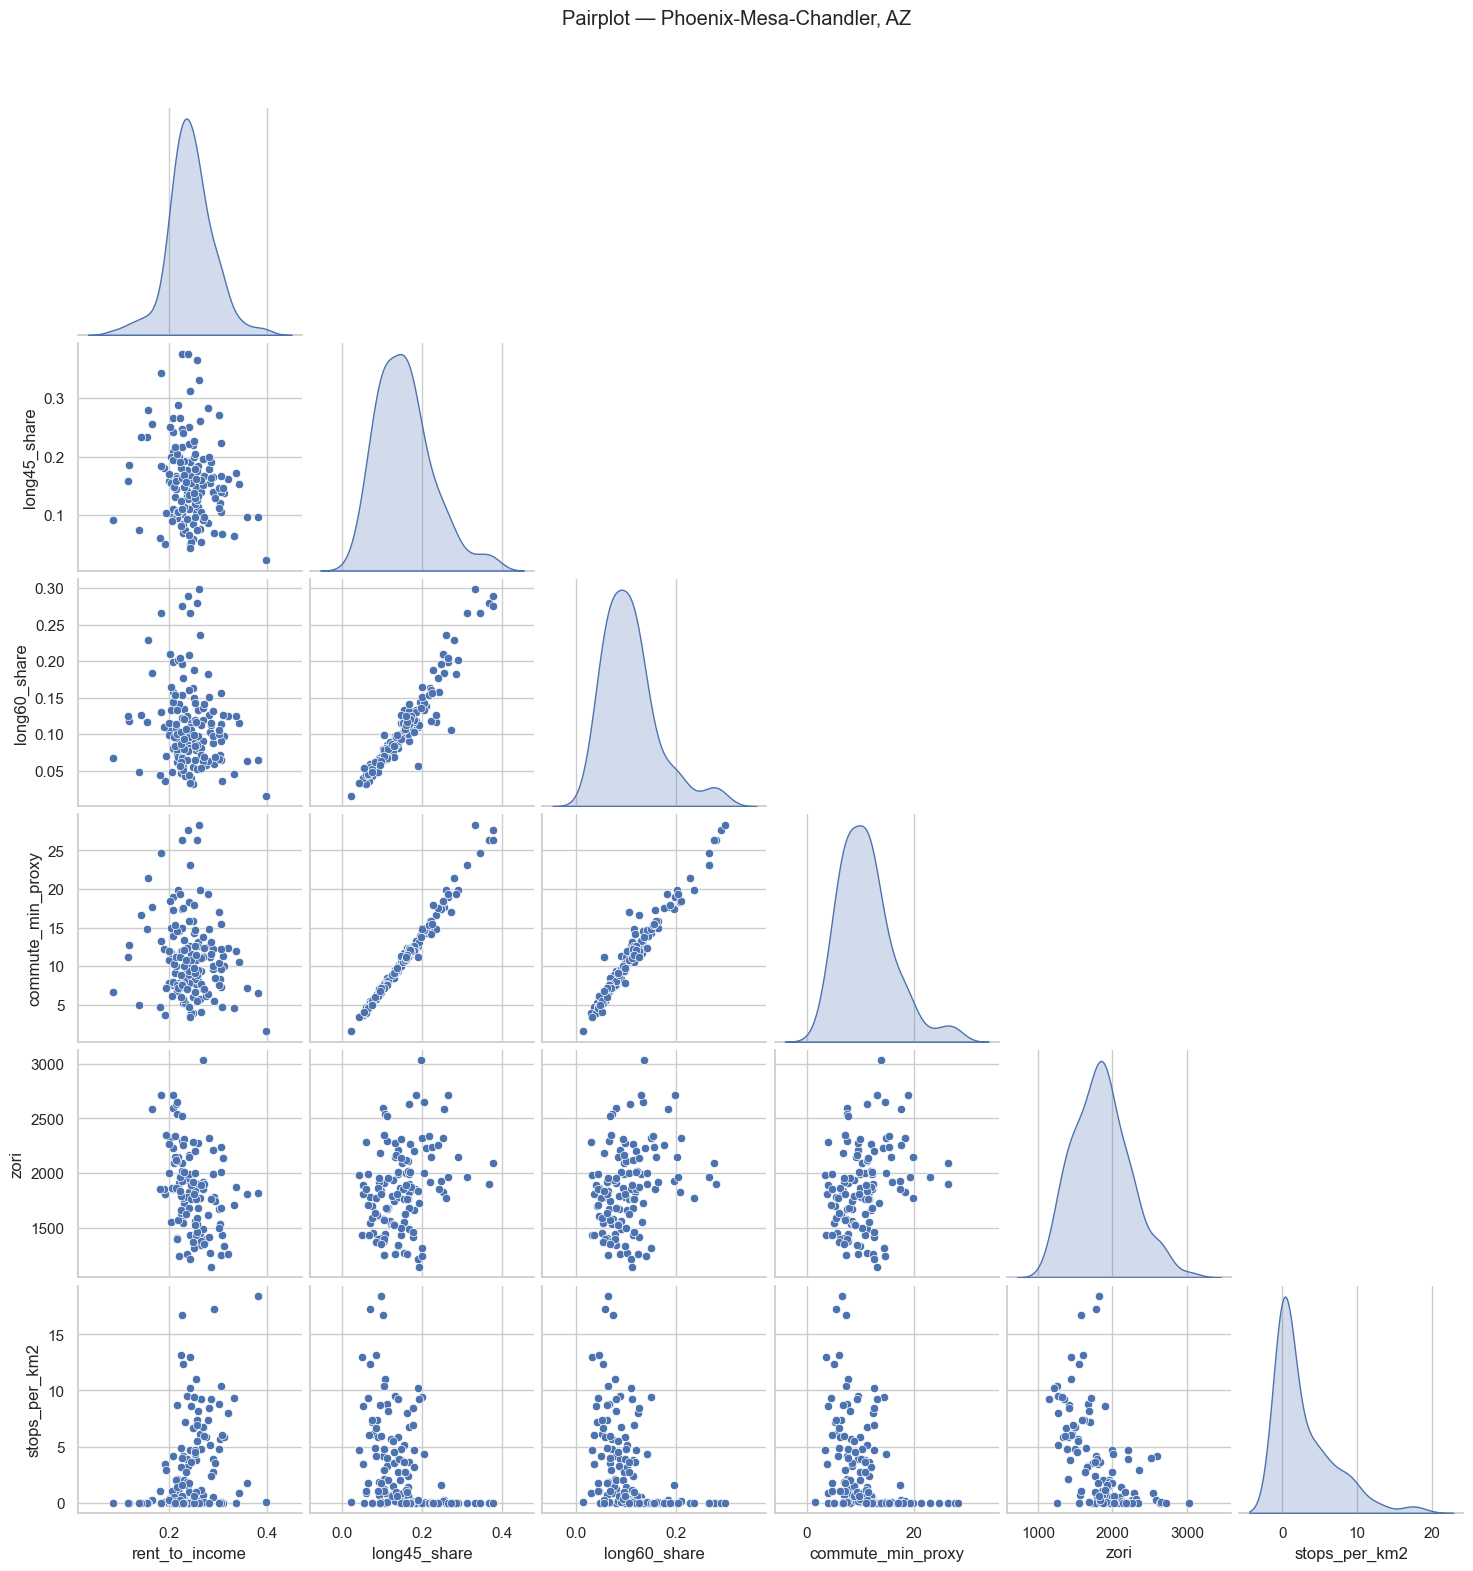

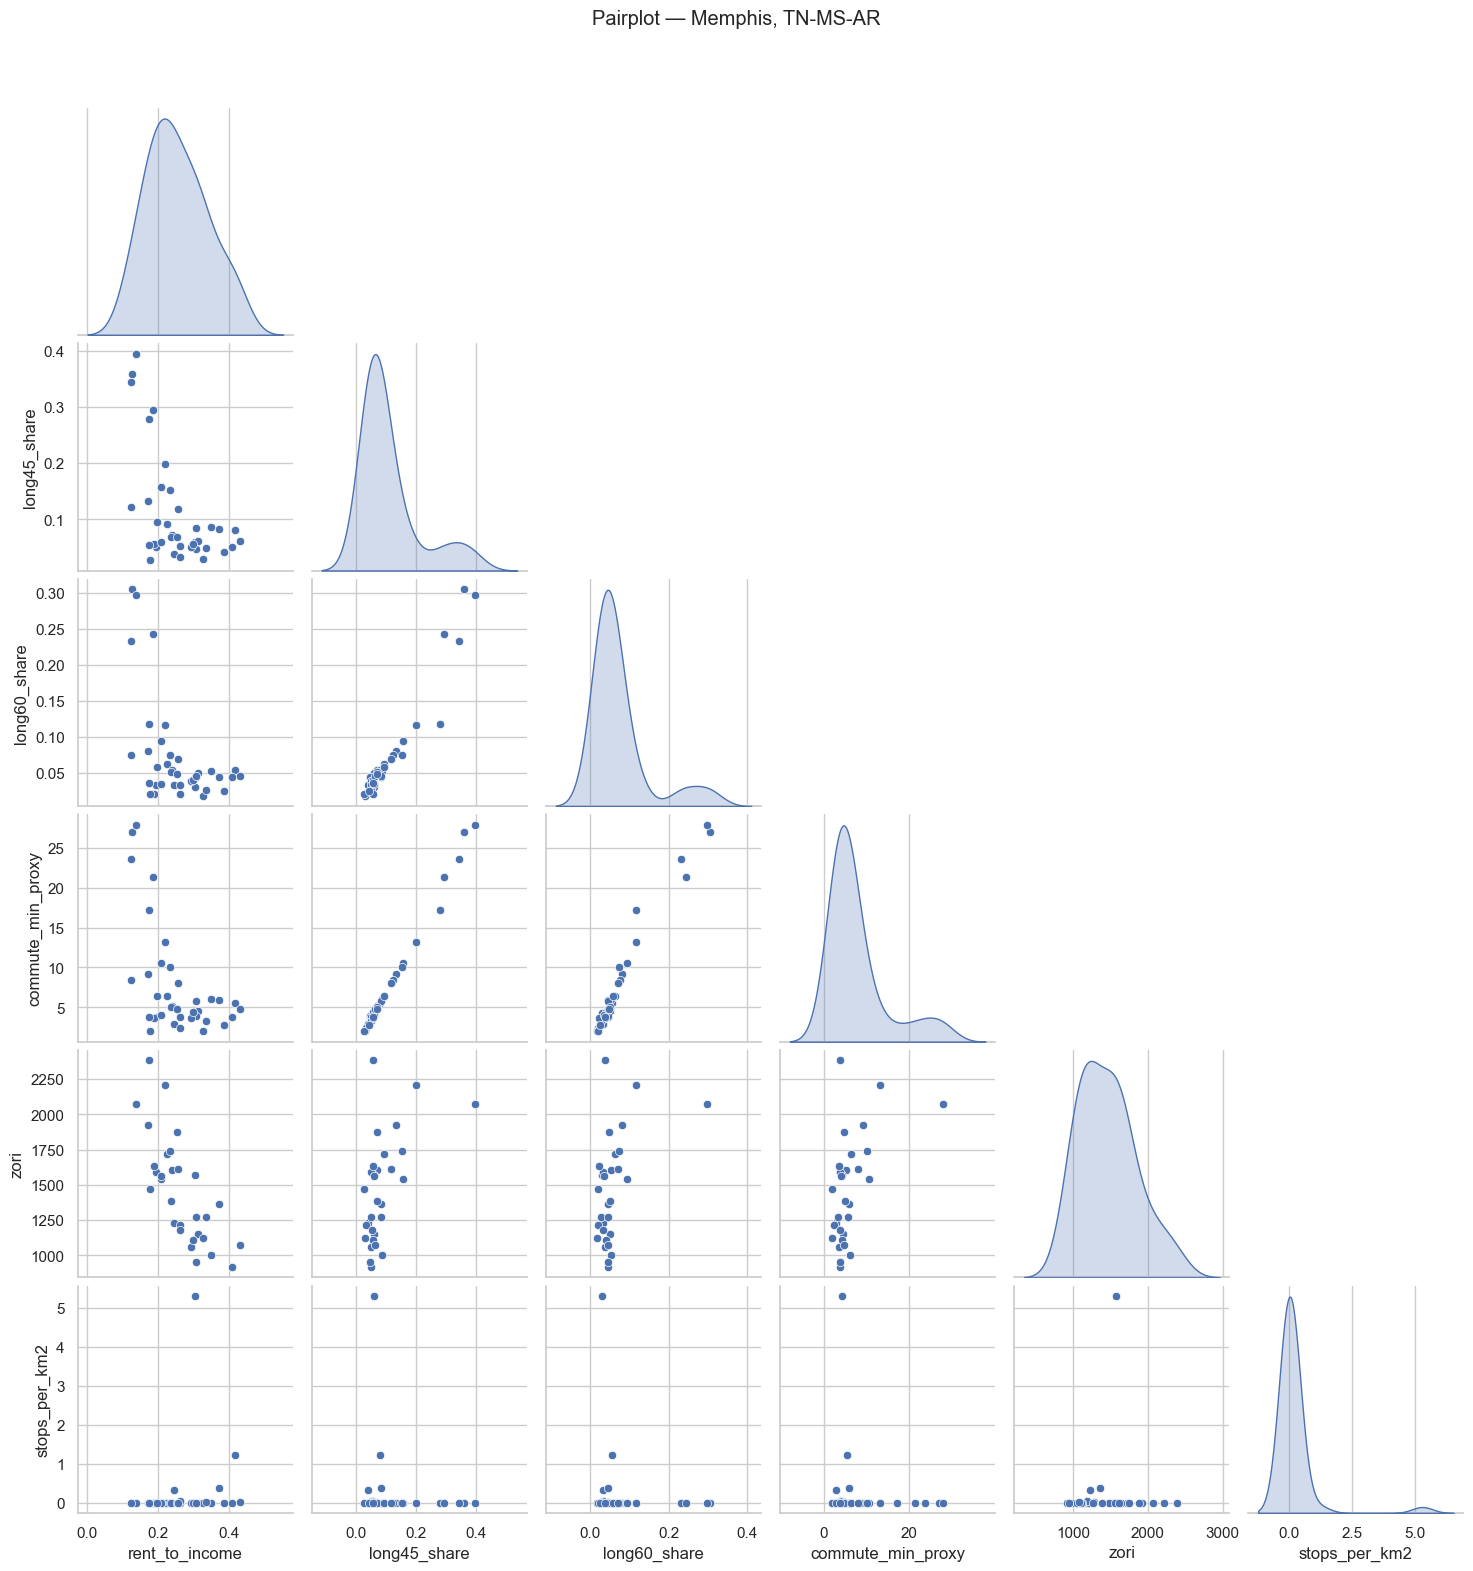

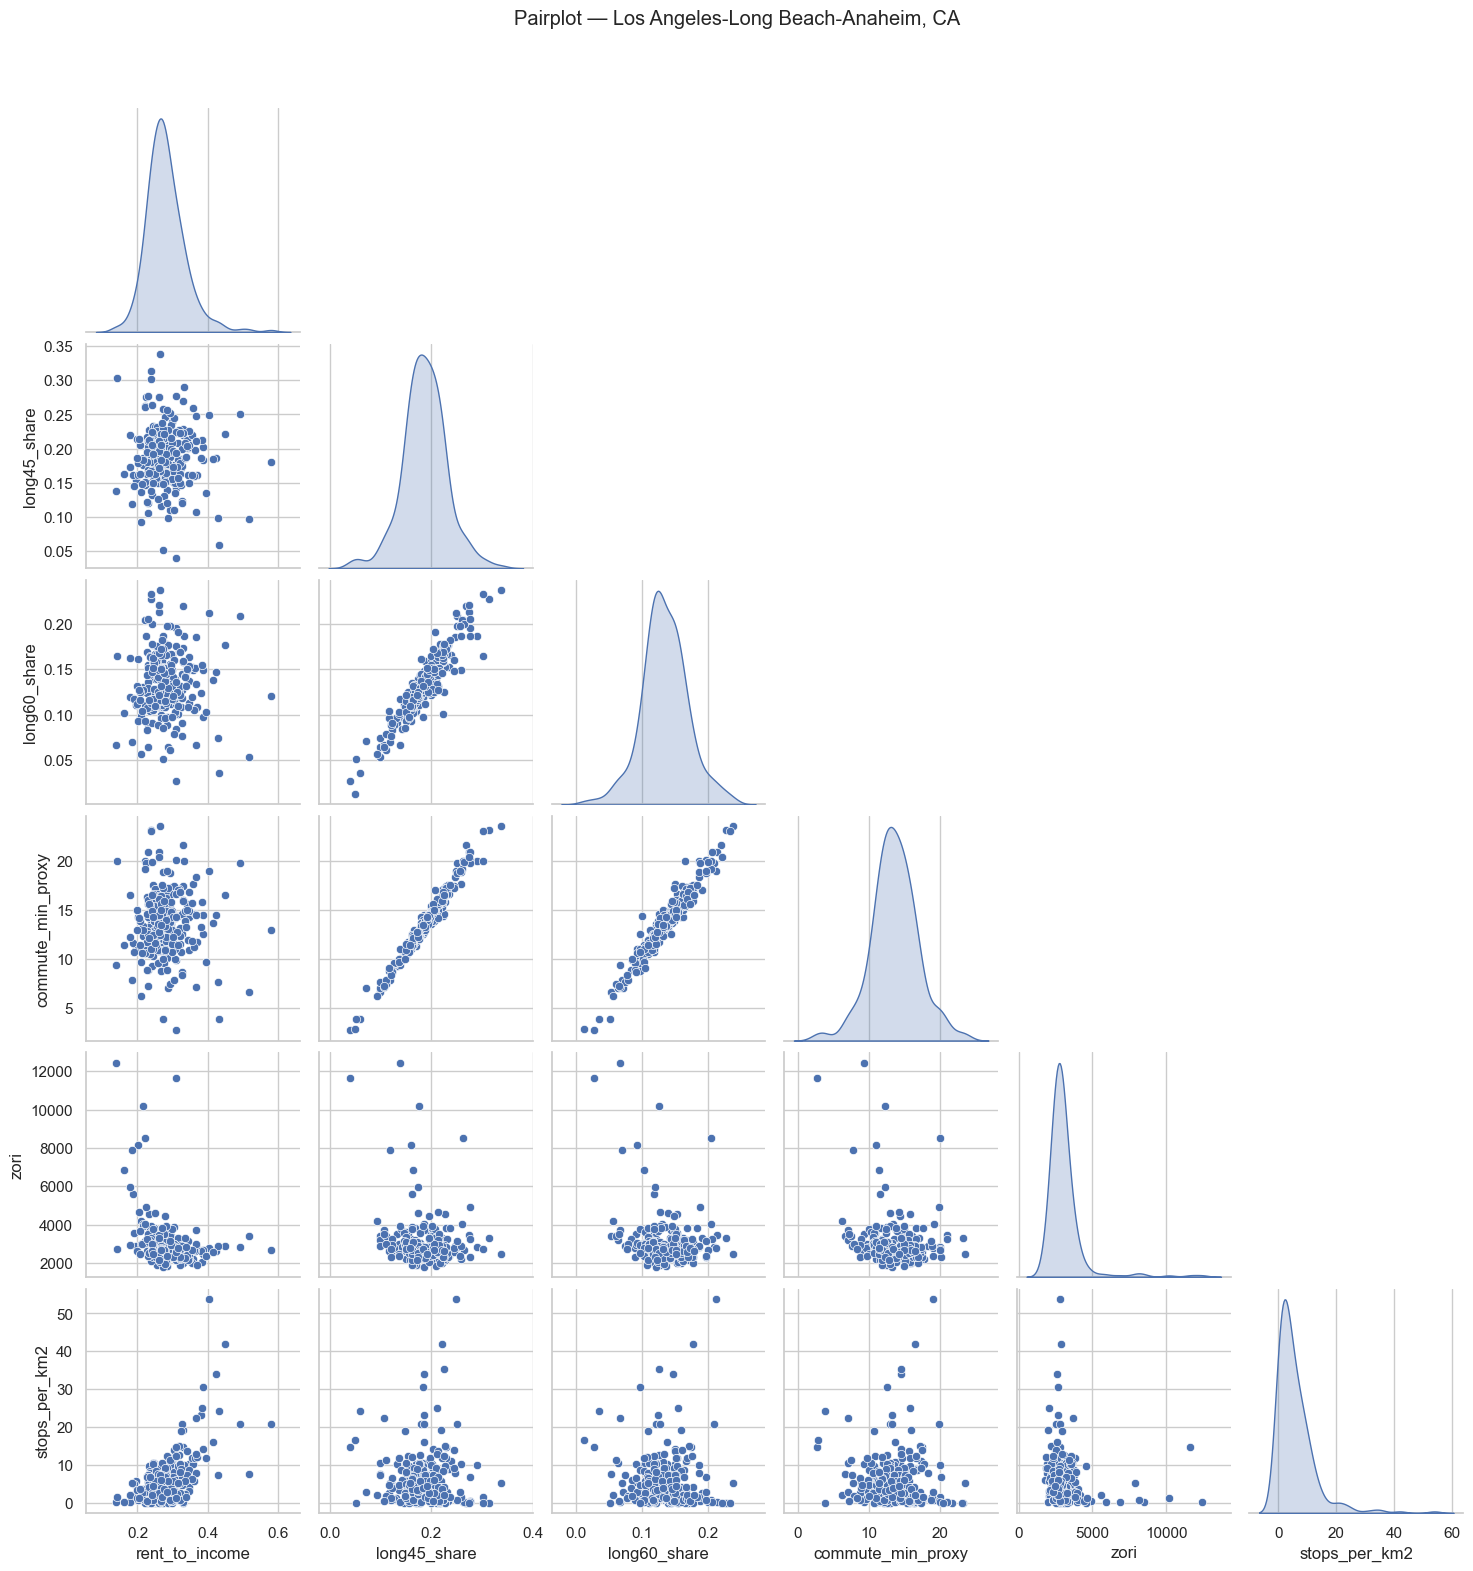

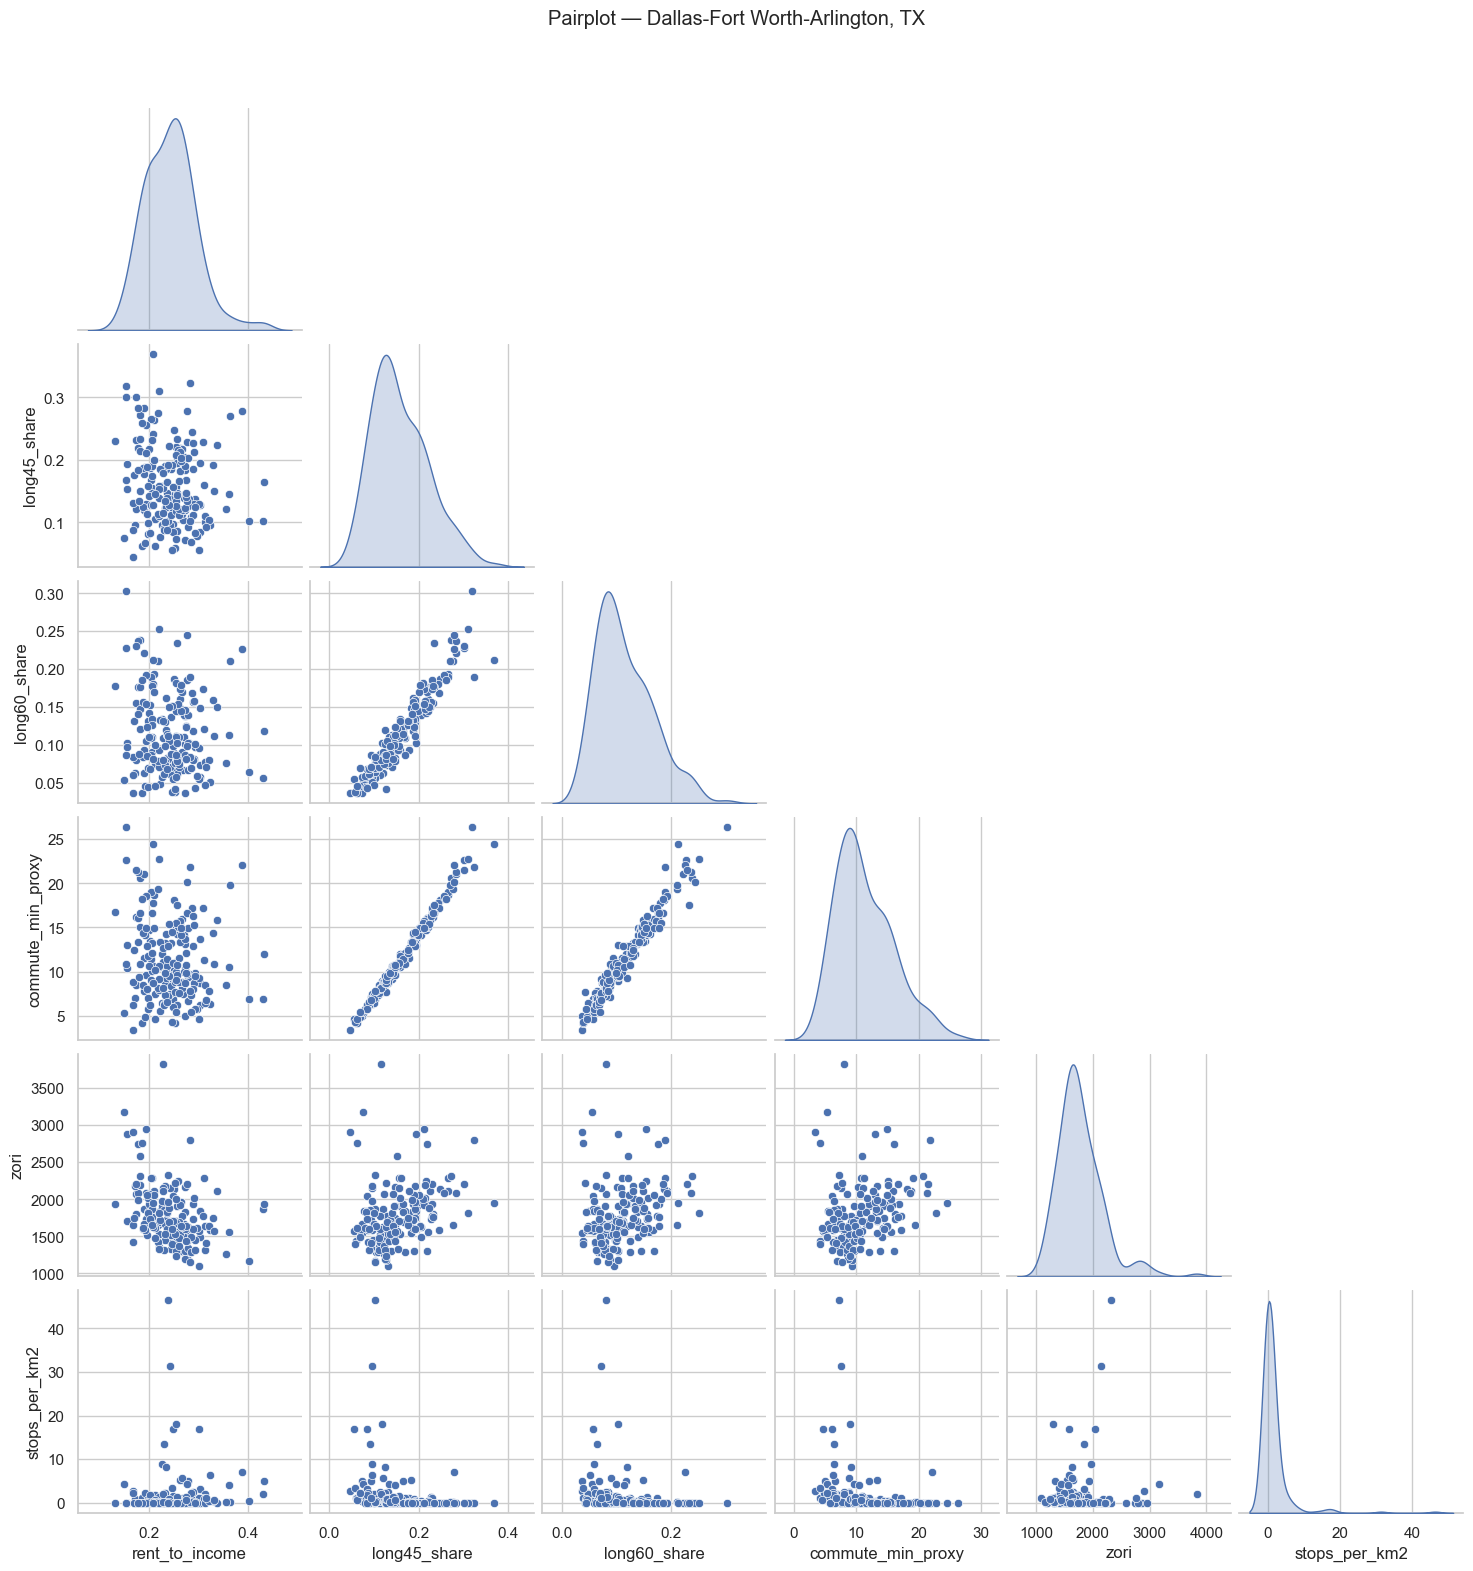

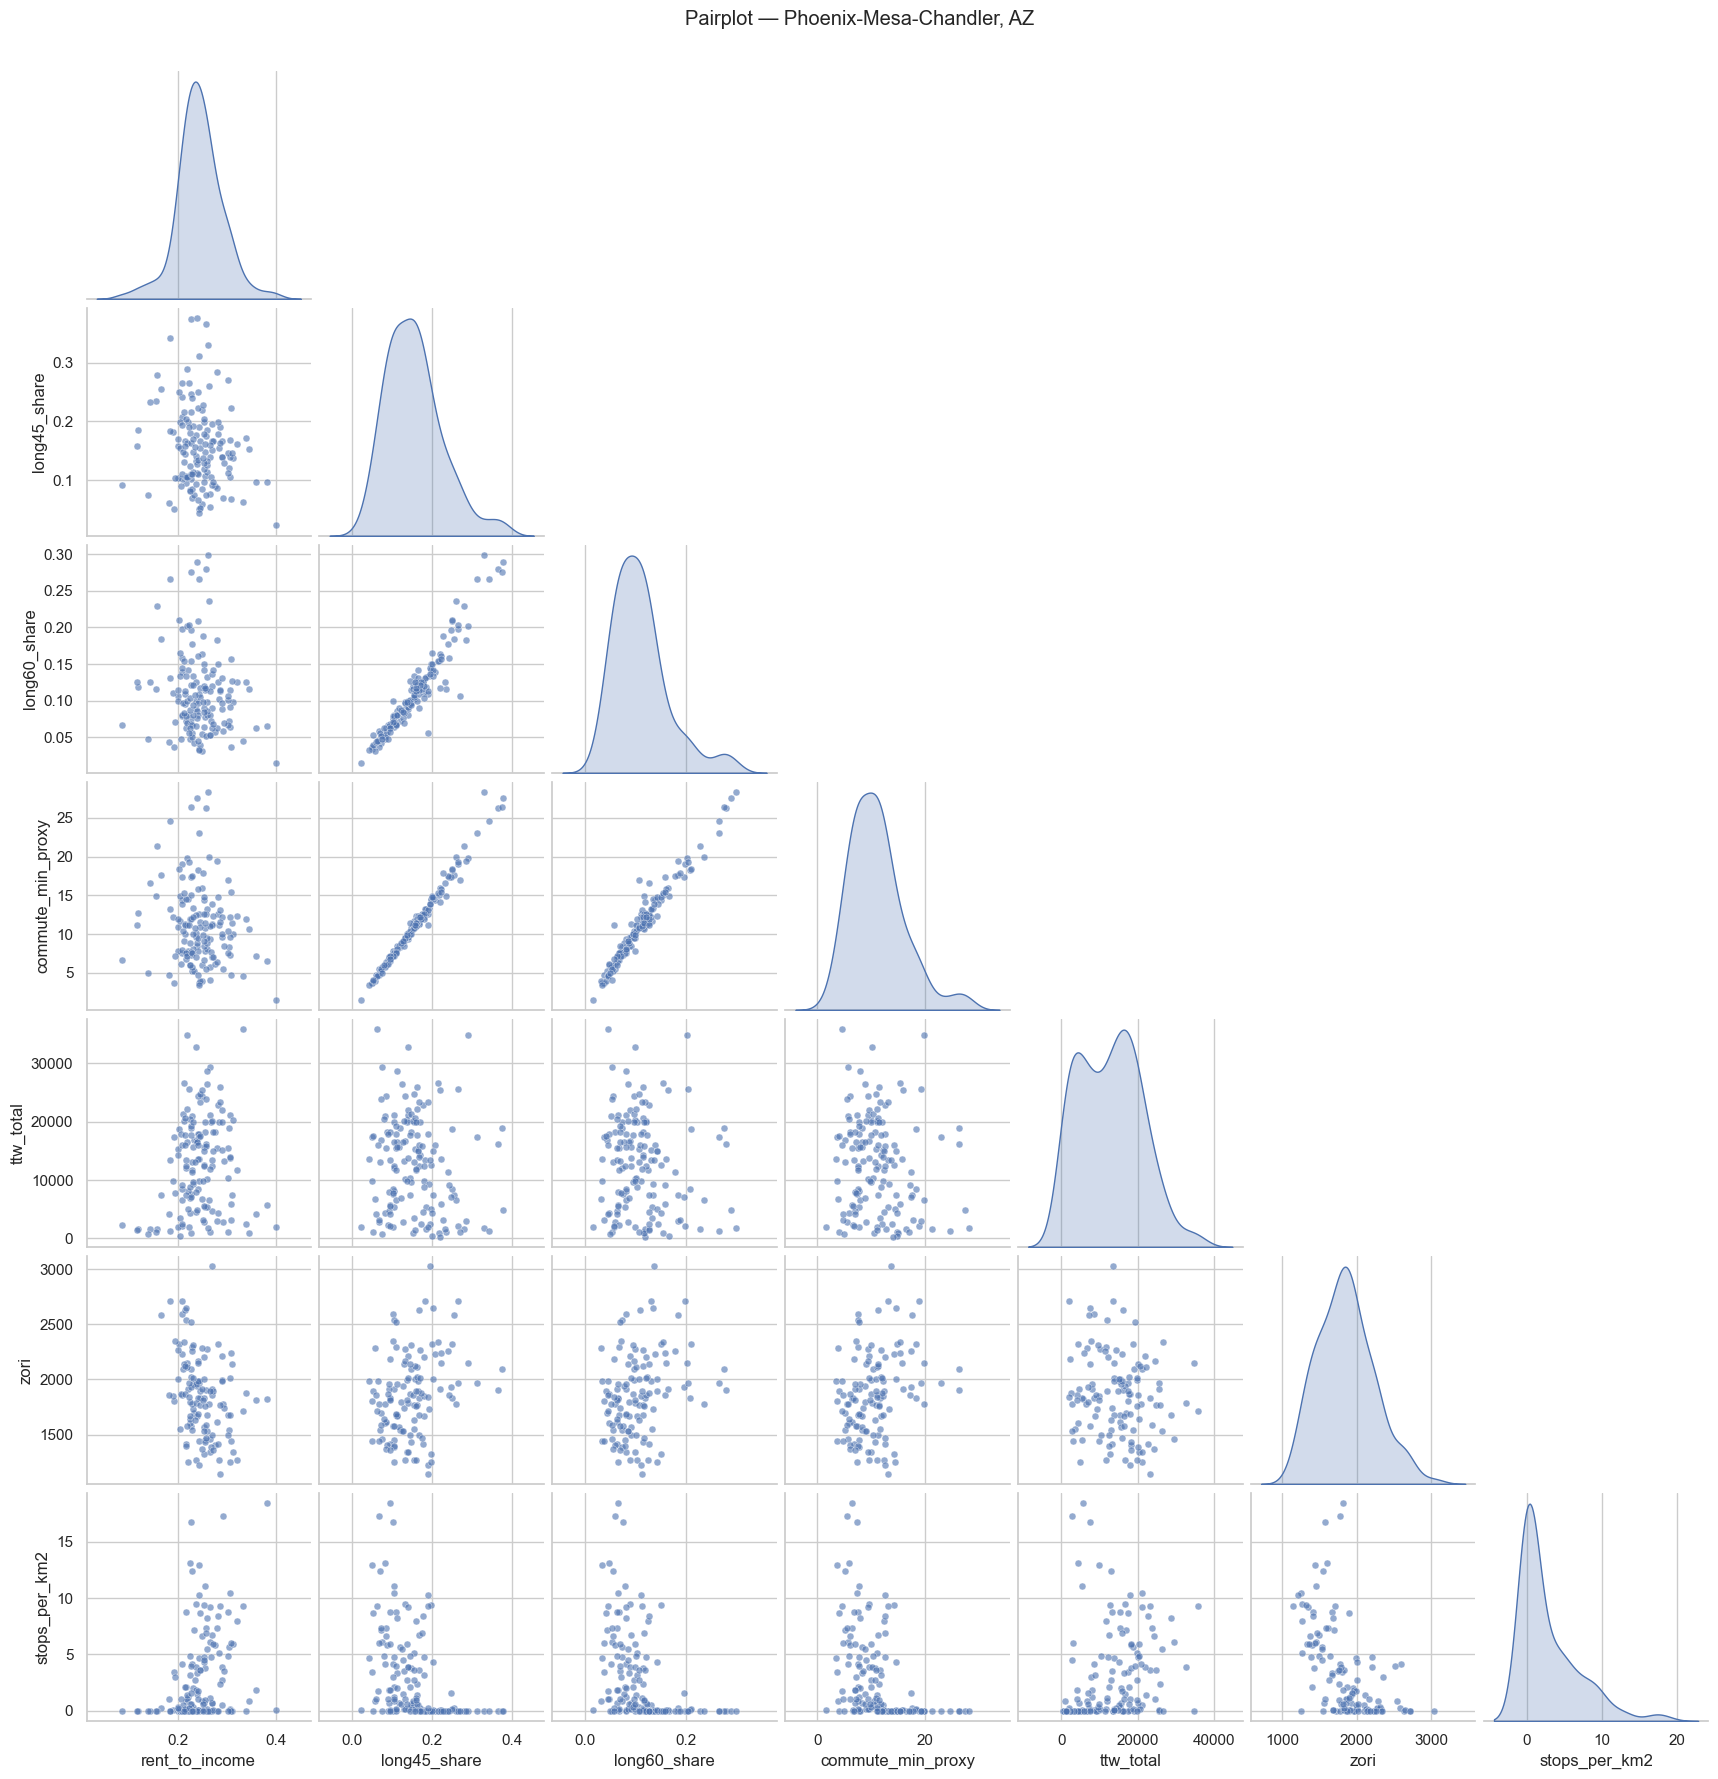

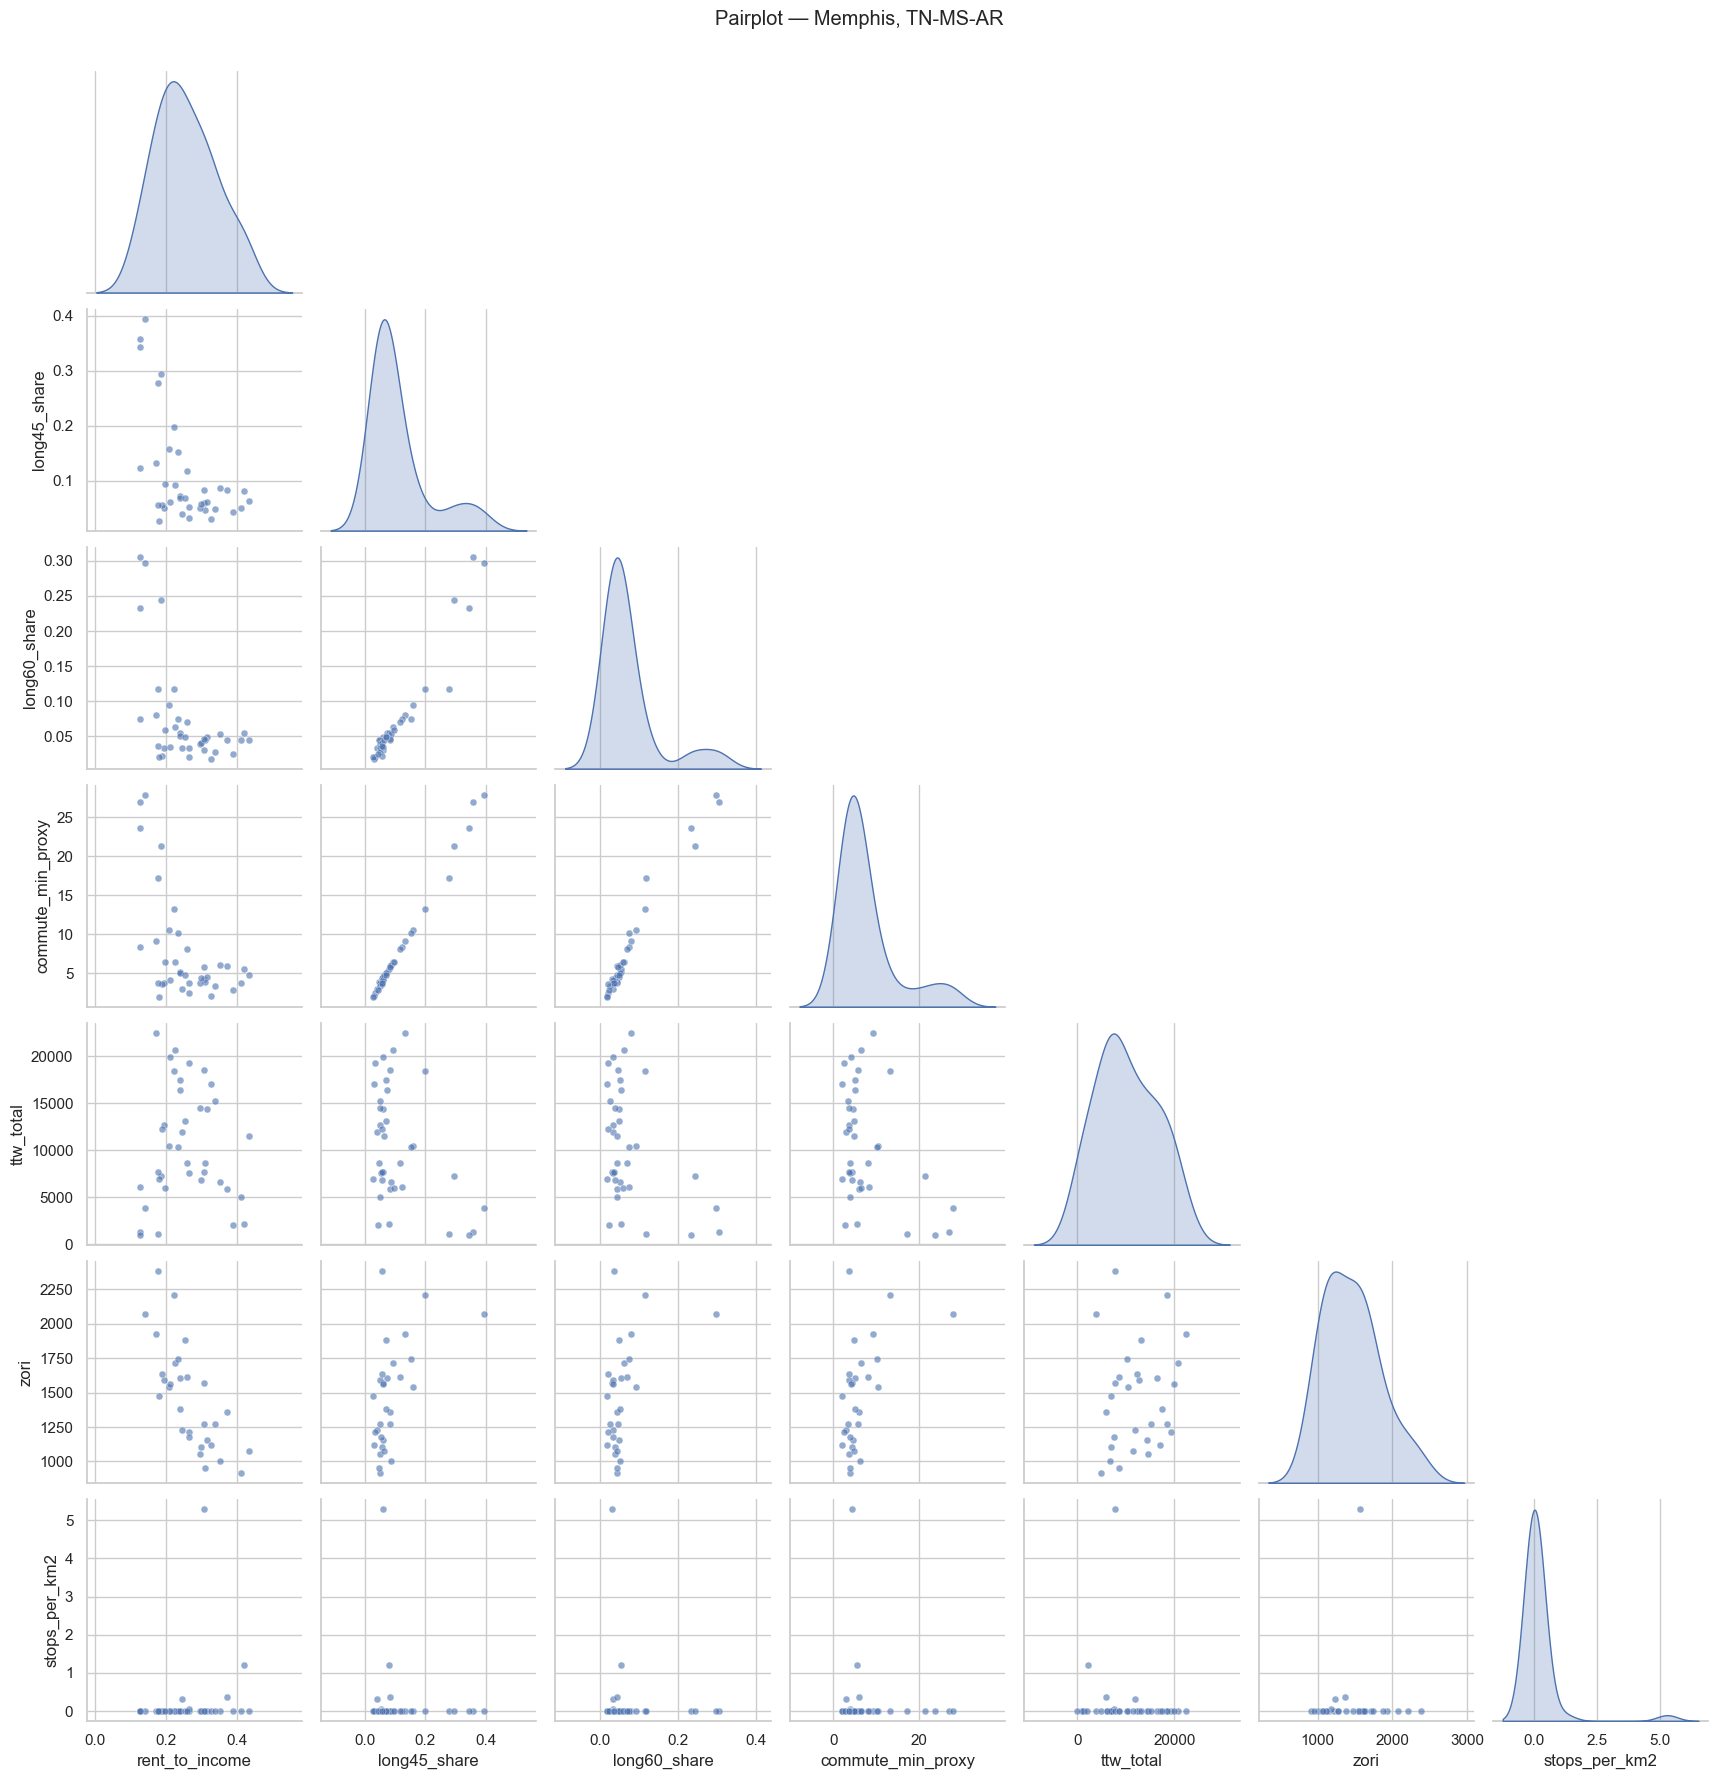

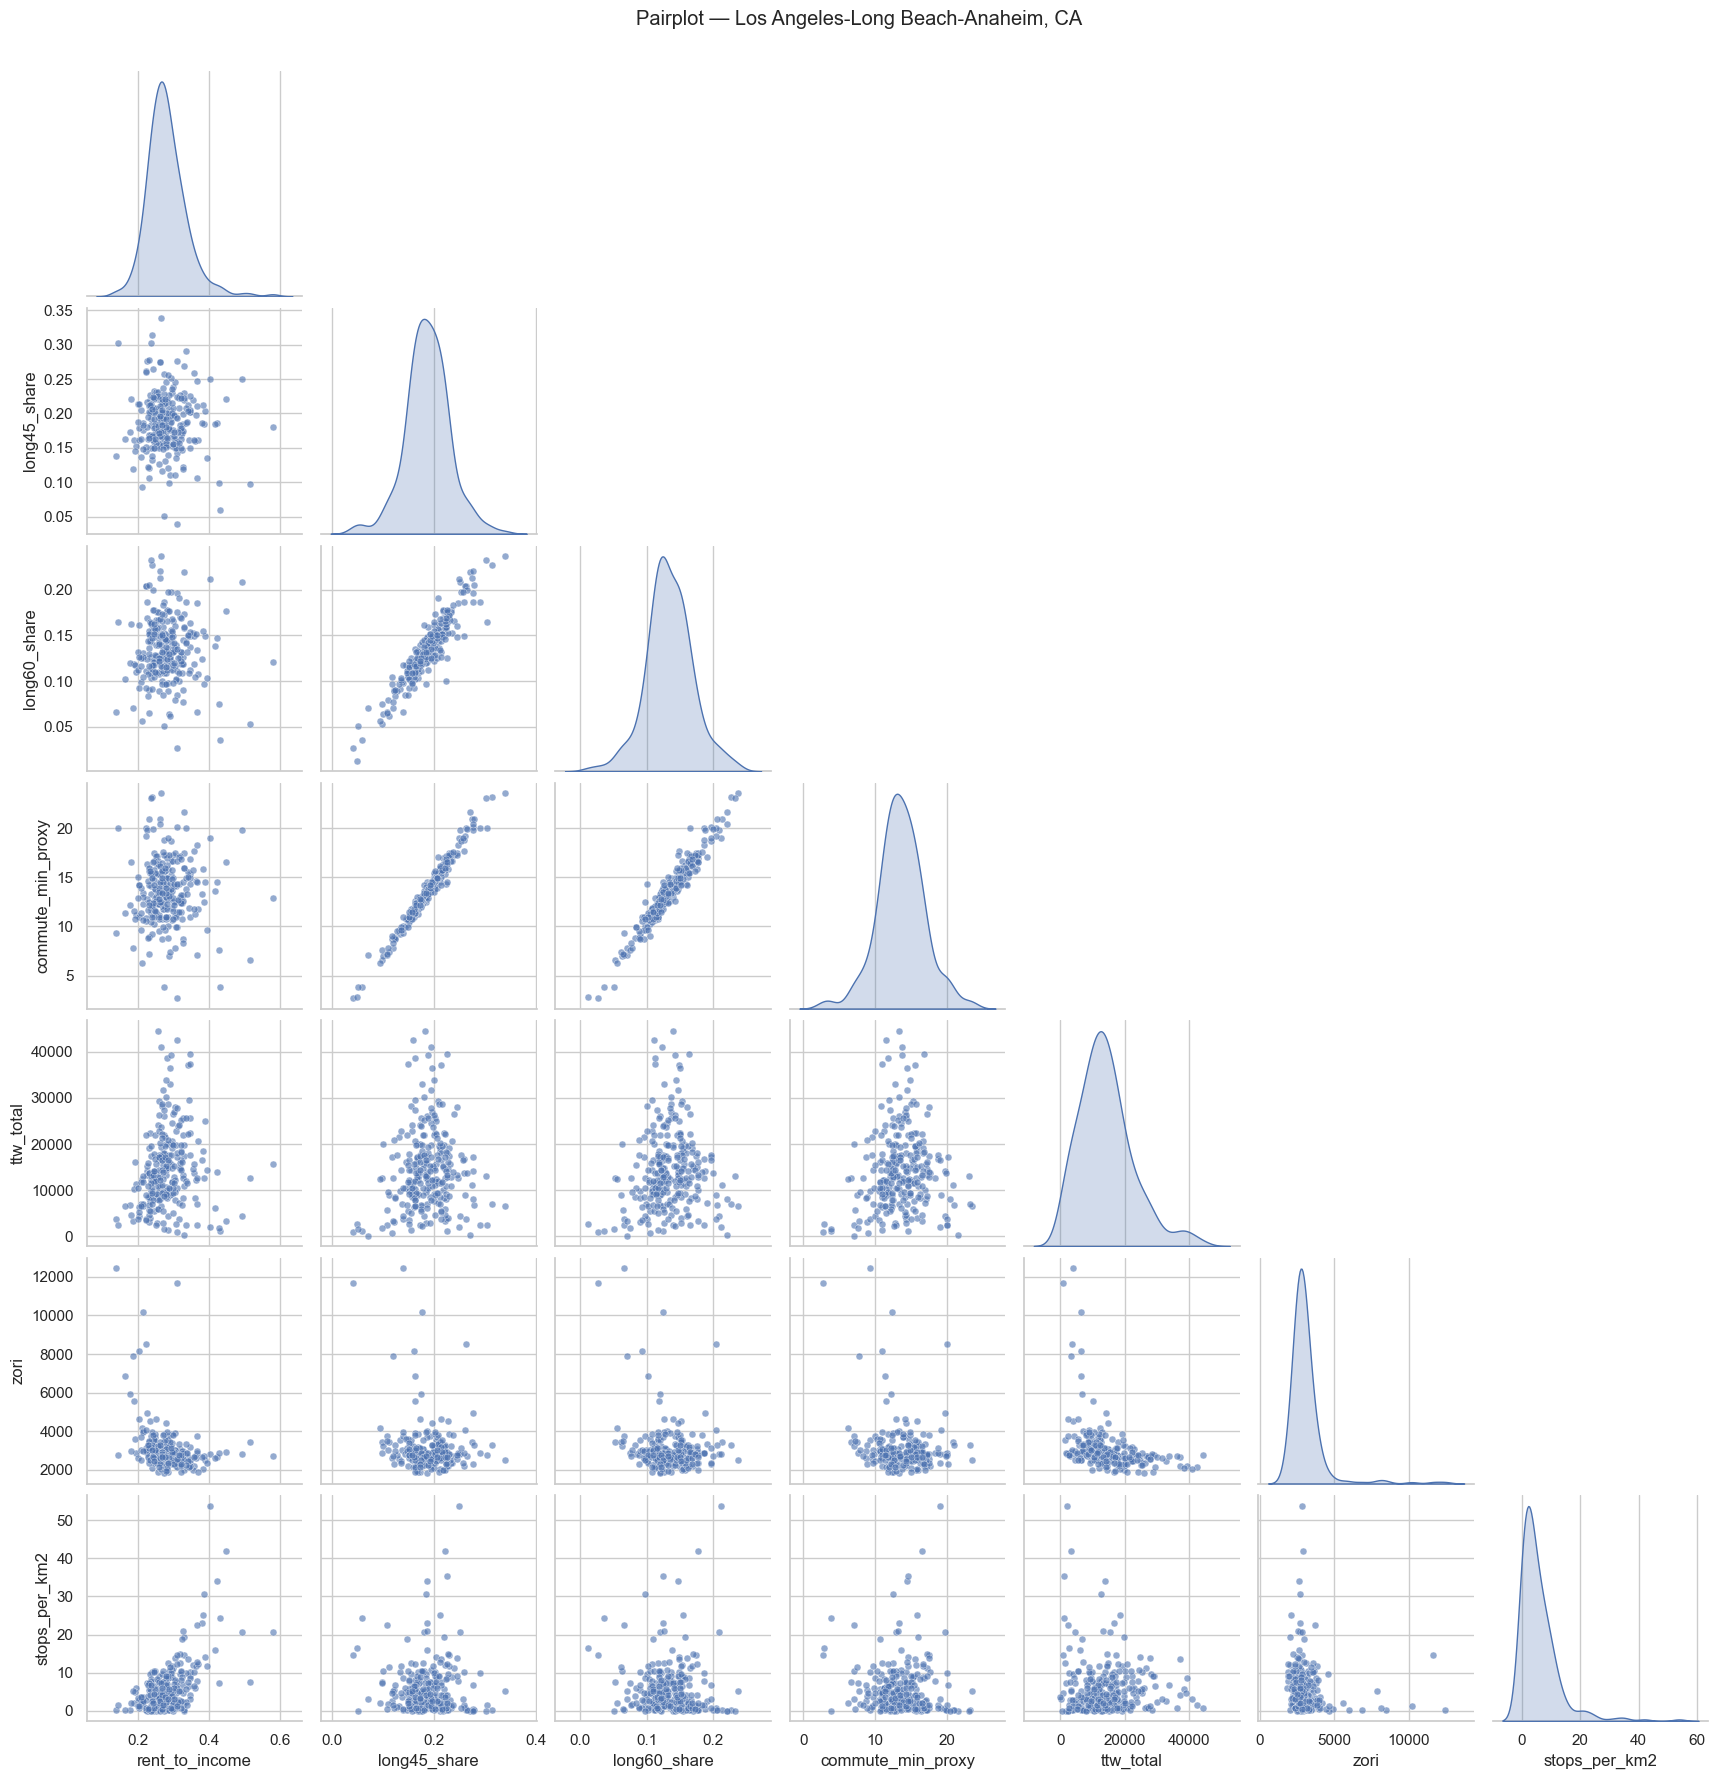

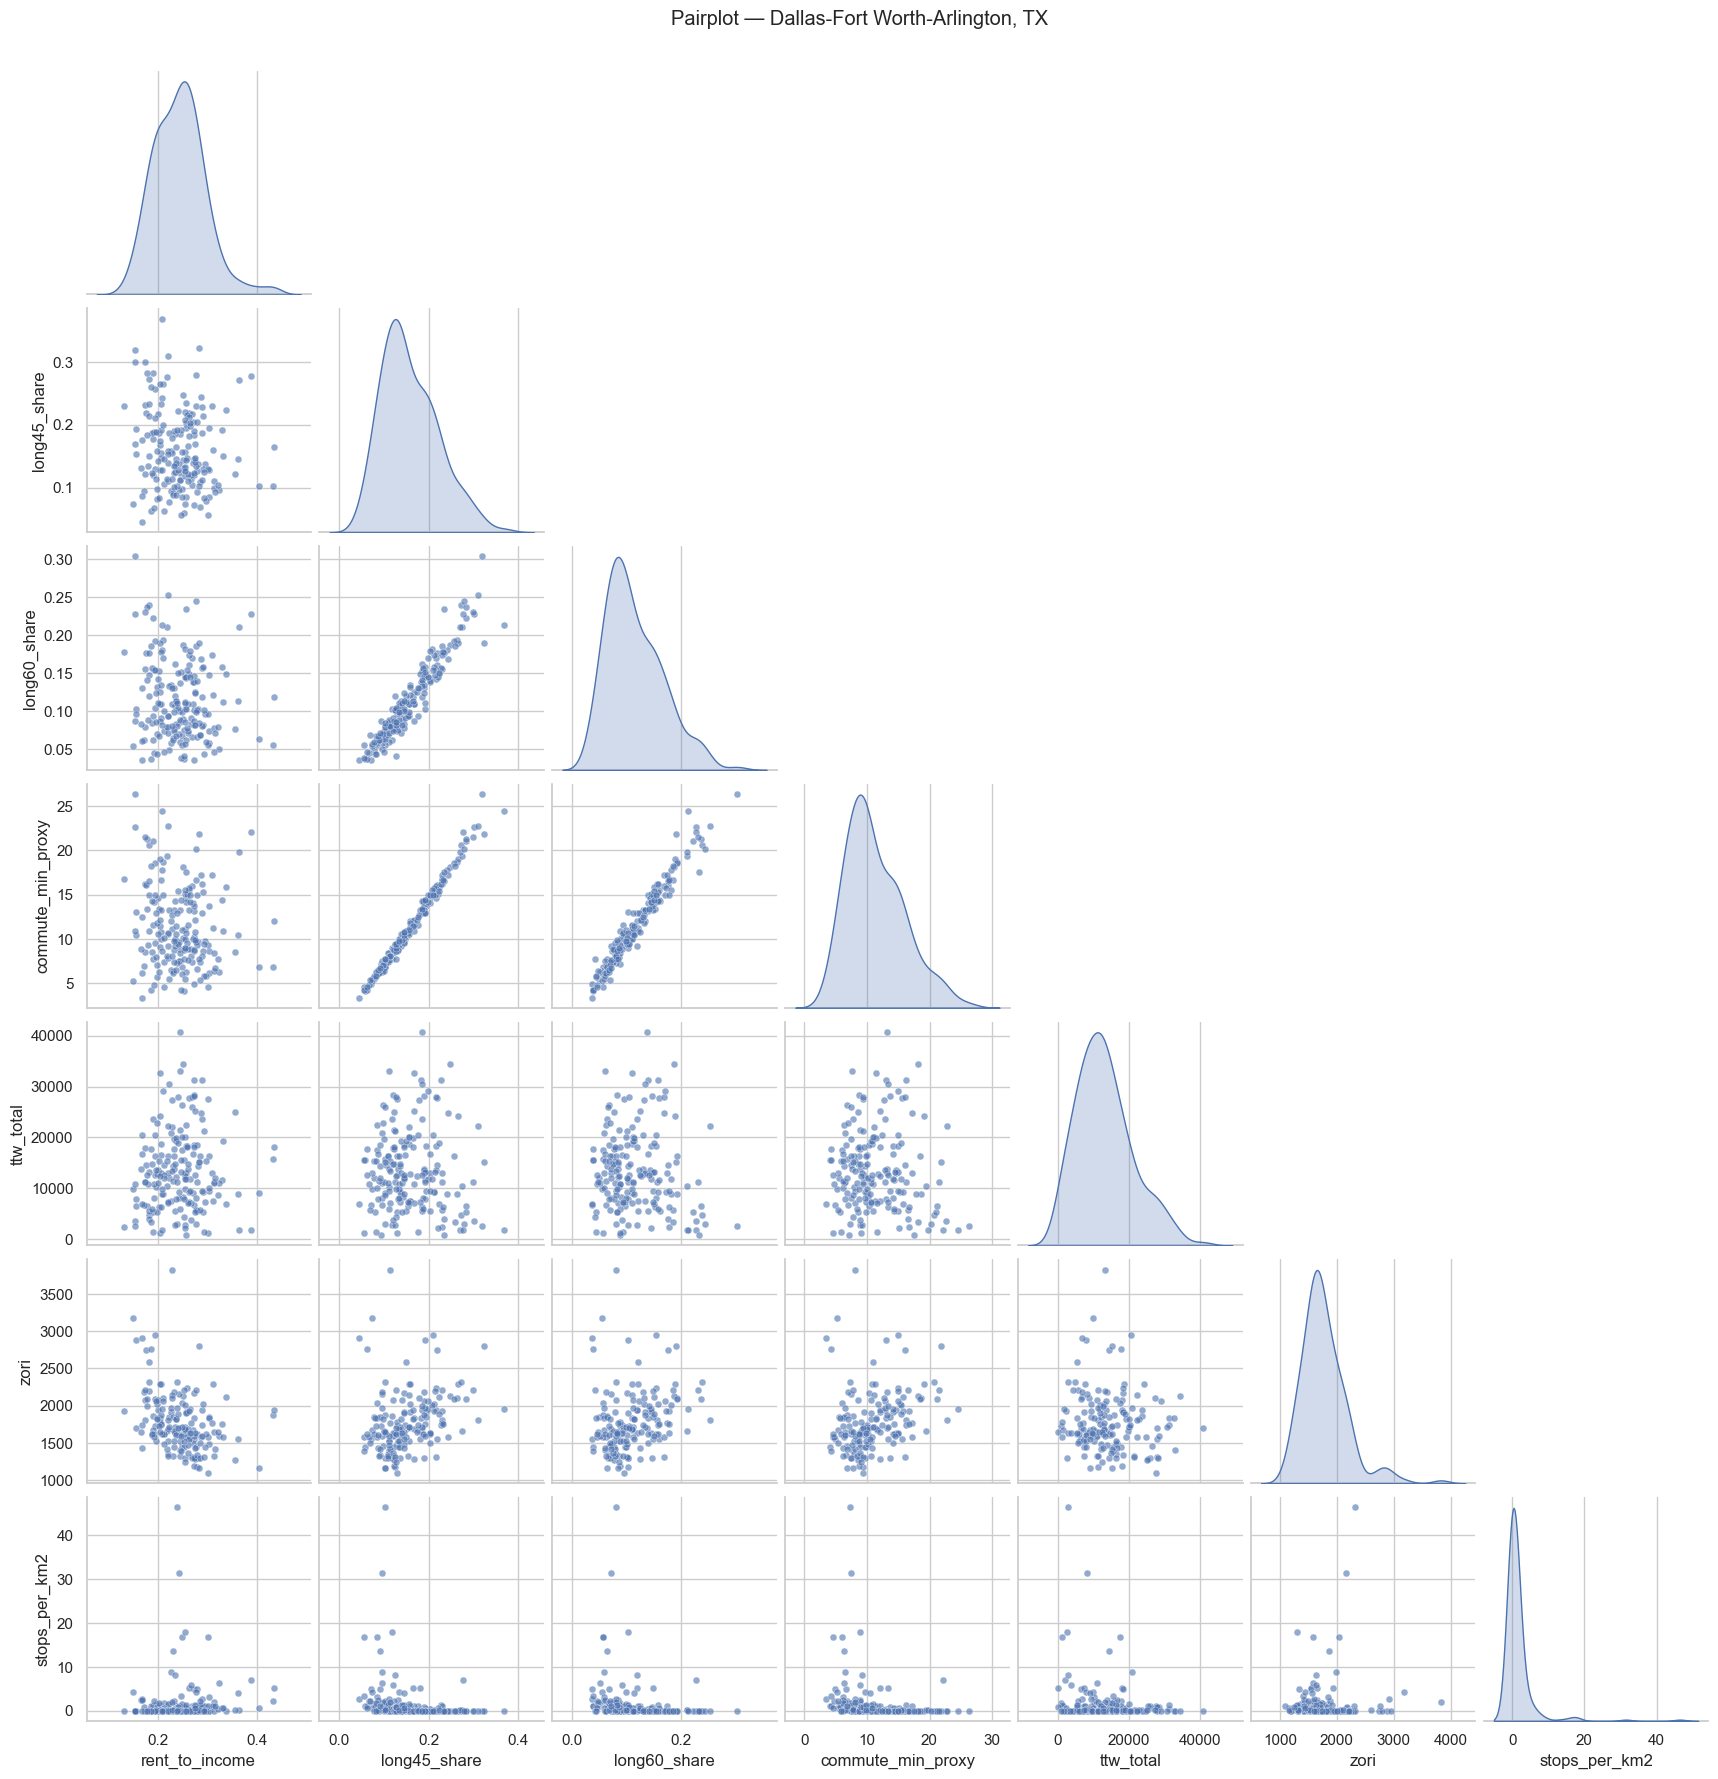

In [21]:
#I think profile is a great starting off point for the EDA. Youll have to literally stop me to not continue.
#Analysis per metro
cols = ["rent_to_income","long45_share","long60_share","commute_min_proxy","ttw_total","zori","stops_per_km2"]

for metro in df["metro_name"].unique():
    subset = df[df["metro_name"] == metro]

    g = sns.pairplot(
        subset[cols],
        diag_kind="kde",
        corner=True,
        plot_kws={"alpha":0.6, "s":25}
    )
    g.fig.suptitle(f"Pairplot — {metro}", y=1.02)
    plt.show()


In [ ]:
#based on what Im seeing I think some calculations need to be standardized. They arent wrong, but they just need to account for differing metro sizes. We should also check the metro areas... I just know my area

In [22]:
# ican do more graphs but im tired


Export report to file: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.79it/s]
